# Análisis de redes de contratación

In [189]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

## Pendientes

- Limpiar el NIT de los contratistas
- Quitar los contratos de prestación de servicios

## Limpieza de datos

In [266]:
contratos = pd.read_csv('SECOP_I_IPS.csv', sep = ';')
contratos.head()

/Users/hfelizzola/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (57) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,UID,Anno Cargue SECOP,Anno Firma del Contrato,Nivel Entidad,Orden Entidad,Nombre de la Entidad,NIT de la Entidad,Código de la Entidad,ID Tipo de Proceso,Tipo de Proceso,...,ID Origen de los Recursos,Origen de los Recursos,Codigo BPIN,Proponentes Seleccionados,Calificacion Definitiva,ID Sub Unidad Ejecutora,Nombre Sub Unidad Ejecutora,Moneda,EsPostConflicto,Ruta Proceso en SECOP I
0,16-4-5459706-4978708,2016,2016.0,TERRITORIAL,TERRITORIAL DEPARTAMENTAL DESCENTRALIZADO,ANTIOQUIA - HOSPITAL GENERAL DE MEDELLÍN,890904646,205001222,4,Régimen Especial,...,0,No definido,-1,No definido,No definido,0,No definida,Pesos (COP),No Definido,https://www.contratos.gov.co/consultas/detalle...
1,18-12-7702955-7155395,2018,2018.0,TERRITORIAL,TERRITORIAL DEPARTAMENTAL DESCENTRALIZADO,ANTIOQUIA - E.S.E. HOSPITAL SANTA MARGARITA - ...,890980949,20521238,12,Contratación Directa (Ley 1150 de 2007),...,0,No definido,-1,No definido,No definido,0,No definida,Pesos (COP),No Definido,https://www.contratos.gov.co/consultas/detalle...
2,17-12-6650779-0,2017,NaN,TERRITORIAL,TERRITORIAL DEPARTAMENTAL DESCENTRALIZADO,VALLE DEL CAUCA - E.S.E. RED DE SALUD DEL CENT...,805027261,276001726,12,Contratación Directa (Ley 1150 de 2007),...,0,No definido,-1,No definido,No definido,0,No definida,No Definida,No Definido,https://www.contratos.gov.co/consultas/detalle...
3,16-4-5460276-4979366,2016,2016.0,TERRITORIAL,TERRITORIAL DEPARTAMENTAL DESCENTRALIZADO,CALDAS - E.S.E. HOSPITAL SAN VICENTE DE PAÚL -...,800191101,21704212,4,Régimen Especial,...,0,No definido,-1,No definido,No definido,0,No definida,Pesos (COP),No Definido,https://www.contratos.gov.co/consultas/detalle...
4,18-12-7900606-7225934,2018,2018.0,TERRITORIAL,TERRITORIAL DEPARTAMENTAL DESCENTRALIZADO,CÓRDOBA - E.S.E. HOSPITAL SAN RAFAEL DE CHINÚ,800193912,223182017,12,Contratación Directa (Ley 1150 de 2007),...,0,No definido,-1,No definido,No definido,0,No definida,Pesos (COP),No Definido,https://www.contratos.gov.co/consultas/detalle...


In [268]:
contratos.shape

(1105606, 62)

### Ajuste de fechas

A continuación se ajustan los nombres de las columnas:

In [269]:
columnas = ['UID','año_cargue','año_firma','nivel_entidad','orden_entidad',
            'nombre_entidad','nit_entidad','cod_entidad','id_tipo_proceso',
            'tipo_proceso','estado_proceso','causal_cont_direct','id_reg_contrat',
            'regimen_contratacion','id_objeto','objeto_contratar','detalle_objeto',
            'tipo_contrato','municipio_obtencion','municipio_entrega',
            'municipio_ejecucion','fecha_cargue','numero_constancia','numero_proceso',
            'numero_contrato','valor_estimado','id_grupo','nombre_grupo','id_familia',
            'nombre_familia','id_clase','nombre_clase','id_adjudicacion',
            'tipo_id_contratista','id_contratista','contratista','departamento_contratista',
            'tipo_id_rep_legal','id_rep_legal','nombre_rep_legal','fecha_firma',
            'fecha_ini_ejec','plazo_ejec','rango_ejec','adiciones_dias','adiciones_meses',
            'fecha_fin_ejec','compromiso_presupuestal','valor_inicial','valor_adiciones',
            'valor_total','objeto_contrato_firma','id_origen_recursos','origen_recursos',
            'codigo_BPIN','proponentes_selecc','calificacion_definitiva','id_sub_unid_ejec',
            'nombre_sub_unid_ejec','moneda','post_conflicto','ruta_web']
contratos.columns = columnas

Se ajusta el formato de fecha en las columnas: fecha de firma, fecha de inicio de ejecución y fecha de fin de ejecución:

In [270]:
col_fechas = ['fecha_firma','fecha_ini_ejec','fecha_fin_ejec']

for i in col_fechas:
    #print(i)
    contratos[i] = pd.to_datetime(contratos[i])

Se eliminan contratos donde el plazo estimado es un NA:

In [271]:
contratos['plazo_estimado'] = contratos['fecha_fin_ejec'] - contratos['fecha_ini_ejec']
contratos = contratos.dropna(subset=['plazo_estimado'])
contratos.shape

(955565, 63)

Se eliminan 150041 contratos (1105606-955565).

In [272]:
contratos['plazo_estimado'].describe()

count                      955565
mean      63 days 03:10:24.458635
std      138 days 22:12:01.871532
min           -334 days +00:00:00
25%               1 days 00:00:00
50%               3 days 00:00:00
75%              62 days 00:00:00
max           19721 days 00:00:00
Name: plazo_estimado, dtype: object

In [273]:
temp = contratos.loc[contratos['plazo_estimado'] < pd.Timedelta(0,'D'), ['fecha_fin_ejec','fecha_ini_ejec','plazo_estimado']]
temp.head()

,fecha_fin_ejec,fecha_ini_ejec,plazo_estimado
6,2016-03-09,2016-08-18,-162 days
9,2017-07-19,2017-09-06,-49 days
67,2016-01-02,2016-02-01,-30 days
86,2016-04-09,2016-08-19,-132 days
105,2016-07-31,2016-11-07,-99 days


In [274]:
temp.shape

(69075, 3)

Hay 69075 contratos donde la fecha de fin del contrato esta antes de la fecha de inicio **¿Que se hace con estos contratos?**

### Convenios interadministrativos

In [275]:
index_conv = contratos.loc[contratos['detalle_objeto'].str.contains('aunar esfuerzos|anuar esfuerzos|aunar espuerzos', regex=True) == True,
                     'detalle_objeto'].index

In [276]:
contratos = contratos.drop(index_conv)
contratos.shape

(955492, 63)

### Contratos de transacciones bancarias y manejo de inmuebles

Se retiran contratos que se refieran a:

- Crédito
- Fiducia
- Comodato
- Arrendamiento

In [281]:
# Se extre el index de los contratos con transacciones bancarias y manejo de inmuebles
trans_banc = ['Crédito','Fiducia','Comodato','Arrendamiento']
index_trans = contratos.loc[contratos['tipo_contrato'].isin(trans_banc)].index
index_trans

Int64Index([], dtype='int64')

In [282]:
contratos = contratos.drop(index_trans)
contratos.shape

(950732, 63)

Ahora se retiran contratos que hablen de emprestitos

In [283]:
index_empres = contratos.loc[contratos['detalle_objeto'].str.contains('empréstito|emprestito|empresito', regex=True) == True].index
index_empres.shape

(0,)

### Contratos de prestación de servicios

In [284]:
index_pres_serv = contratos[contratos['tipo_contrato'] == 'Prestación de Servicios'].index
contratos = contratos.drop(index_pres_serv)
contratos.shape

(281746, 63)

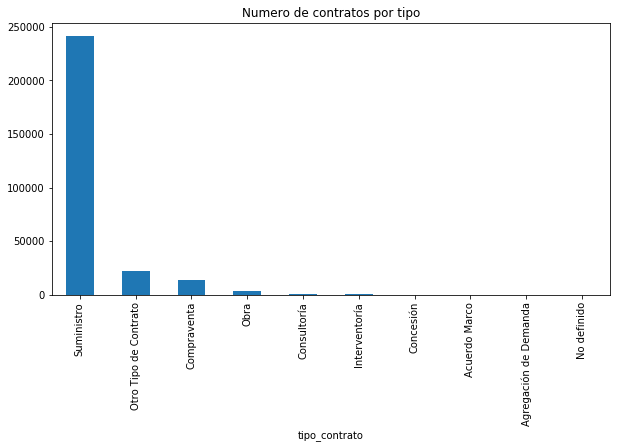

In [285]:
plt.figure(figsize=(10,5))
contratos.groupby(['tipo_contrato']).size().sort_values(ascending = False).plot.bar()
plt.title("Numero de contratos por tipo")
plt.show()

### Año de cargue vs año de registro

Eliminar contratos con año de firma o cargue antes de 2014

In [286]:
index_antes_2014 = contratos.loc[(contratos['año_firma'] < 2014) | (contratos['año_cargue'] < 2014)].index
index_antes_2014

Int64Index([    430,    4177,   17142,   17233,   17234,   20967,   21573,
              23539,   24263,   24556,
            ...
            1089650, 1089755, 1089940, 1090005, 1090461, 1090867, 1092106,
            1104821, 1105259, 1105267],
           dtype='int64', length=4953)

In [287]:
contratos = contratos.drop(index_antes_2014)
contratos.shape

(276793, 63)

Se depuran los registros en el cuales el *año de cargue* $>$ *año de firma*

In [288]:
contratos.groupby(['año_firma']).size()

año_firma
2014.0    23257
2015.0    58976
2016.0    60412
2017.0    56544
2018.0    65516
2019.0    12088
dtype: int64

In [289]:
contratos.groupby(['año_cargue']).size()

año_cargue
2014    18046
2015    61053
2016    57317
2017    50273
2018    74512
2019    15592
dtype: int64

In [290]:
index_carg_inco = contratos.loc[(contratos['año_cargue'] > contratos['año_firma']) == True].index
contratos = contratos.drop(index_carg_inco)
contratos.shape

(246810, 63)

### NIT de los contratistas

Una limpieza inicial consistira en:

- Quitar espacios en blanco
- Quitar caracteres especiales como: `.` `,` `-` `¿?` `\` `|`
- Quitar texto
- Ajustar el NIT de personas juridicas a 9 digitos
- Ajustar el id de personas naturales al maximo permitido por el gobierno
- Quitar registros con id en blanco
- Quitar id con regi

In [291]:
# Unicos id de contratistas
contratos.groupby(['id_contratista']).size()

id_contratista
-4                   1
-6                   1
.                    1
. 18.3511.935 - 1    1
. 23965790-5         1
                    ..
 900.306.068-1       1
 9001322031          2
 900294380-1         1
 900544826-6         5
 9005448266          2
Length: 35276, dtype: int64

In [292]:
# Se quita todo lo que no sea numerico
contratos['id_contratista_mod'] = contratos.id_contratista.str.replace(r'\D', '')
# El codigo de abajo es para quitar caracteres especiales
# contratos['id_contratista_mod'] = contratos['id_contratista_mod'].str.replace('\.|\-|\$|\?|\¿', '')

In [293]:
contratos.groupby(['id_contratista_mod']).size()

id_contratista_mod
             57
0             6
00000         1
000000        1
0000000       1
             ..
9976068       4
998488463     1
9993456       5
9994361       1
9994846       1
Length: 31137, dtype: int64

Pasamos de **35276 a 31137** id de contratistas unicos

In [261]:
contratos['id_contratista_mod'].to_csv('id_contratista.csv')

/Users/hfelizzola/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


## Construir la matriz de adyacencia

In [319]:
red = contratos.groupby(['nit_entidad','id_contratista_mod']).size().sort_values(ascending = False).reset_index()
red.shape

(46282, 3)

In [330]:
red.columns = (['Entidad','Contratista','Contratos'])
red.Contratos.describe()

count    46282.000000
mean         5.332743
std         34.320018
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max       1948.000000
Name: Contratos, dtype: float64

Hacer algunos filtros por el numero de contratos entre entidades

In [324]:
red.loc[red['Contratos'] > 100].shape

(295, 3)

Se gráfica la distribución del numero de contratos

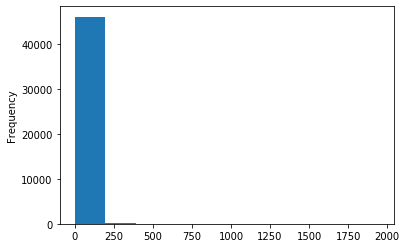

In [328]:
red.Contratos.plot.hist()
plt.title("H")
plt.show()